# Using numpy to sample from trained decoder

In [1]:
import sys
sys.path.insert(0, '../molecules')
sys.path.insert(0, '..')

In [2]:
import numpy as np
import nltk
from nltk.parse.generate import generate
import tensorflow as tf
import keras.backend as K
from random import shuffle

import model_gr_prev
import the_grammar as G

Using TensorFlow backend.


## Create a VAE and load the trained equation weights

In [3]:
vae = model_gr_prev.MoleculeVAE()

productions = G.GCFG.productions()
n_chars = len(productions)
MAX_LEN = model_gr_prev.MAX_LEN
weights_file = "../results/eq_prev_train_vae_h50_c123_cond_L10.hdf5"

vae.load(productions, weights_file, latent_rep_size=10, max_length=MAX_LEN)

## Generate some synthetic data

In [4]:
parser = nltk.ChartParser(G.GCFG)

limit = 100
raw = []
data = []
for tokens in generate(G.GCFG, depth=5, n=limit):
    raw.append(''.join(tokens))
    data.append(parser.parse(tokens).next().productions())

prod_map = {}
for ix, prod in enumerate(productions):
    prod_map[prod] = ix

X = np.zeros((limit, model_gr_prev.MAX_LEN, n_chars), dtype=np.float32)
for row, prods in enumerate(data):
    for t, pr in enumerate(prods):
        X[row,t,prod_map[pr]] = 1
    X[row,t+1:,:] = 1

Encode first batch of data.

In [5]:
batch_size = 100

# batch_indices = np.arange(batch_size)
batch_indices = np.random.randint(limit) * np.ones((batch_size,), dtype=int)

Z = vae.encoder.predict(X[batch_indices])

## uncomment to get a mean estimate instead?
Z = Z / 100.
for i in xrange(1,100):
    Z += vae.encoder.predict(X[:batch_size])/100.
    
print Z.shape
print batch_indices[0]

(100, 10)
19


## For the decoder, grab the output of the next-to-last layer.

We'll do this instead of using `vae.decoder.predict`, until sampling for the final layer is implemented in Keras.

In [6]:
ins = vae.decoder.layers[0].input
next_to_last = vae.decoder.layers[-2].output

get_output_from_input = K.function([ins], [next_to_last])
final_layer_input = get_output_from_input([Z])[0]

final_layer_input.shape

(100, 15, 50)

In [7]:
print vae.decoder.layers[-1].inner_activation
print vae.decoder.layers[-1].activation

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def hard_sigmoid(x):
    x = 0.2*x + 0.5
    return np.clip(x, 0.0, 1.0)

def pop_or_Q(S):
    try:
        return S.pop()
    except:
        return 'Q'
    
lhs_map = {}
for ix, lhs in enumerate(G.lhs_list):
    lhs_map[lhs] = ix


<function hard_sigmoid at 0x11d24c230>
<function tanh at 0x11d24c140>


"Hard sigmoid" is a piecewise linear approximation to a sigmoid function.

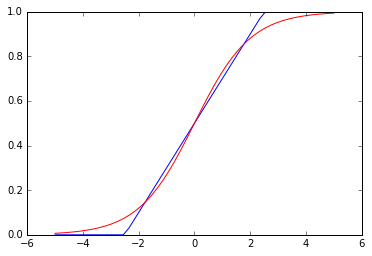

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(np.linspace(-5,5), hard_sigmoid(np.linspace(-5,5)))
plt.plot(np.linspace(-5,5), sigmoid(np.linspace(-5,5)), 'r');

Grab all weights from the final layer, and replicate the logic in numpy.

In [9]:
W_z = K.eval(vae.decoder.layers[-1].W_z)
W_h = K.eval(vae.decoder.layers[-1].W_h)
W_r = K.eval(vae.decoder.layers[-1].W_r)
b_z = K.eval(vae.decoder.layers[-1].b_z)
b_h = K.eval(vae.decoder.layers[-1].b_h)
b_r = K.eval(vae.decoder.layers[-1].b_r)
U_z = K.eval(vae.decoder.layers[-1].U_z)
U_h = K.eval(vae.decoder.layers[-1].U_h)
U_r = K.eval(vae.decoder.layers[-1].U_r)
Y = K.eval(vae.decoder.layers[-1].Y)


In [10]:

ln_p = np.zeros((batch_size,))


x_z = np.dot(final_layer_input, W_z) + b_z
x_h = np.dot(final_layer_input, W_h) + b_h
x_r = np.dot(final_layer_input, W_r) + b_r


h = np.zeros((batch_size, n_chars))
y = np.zeros((batch_size, n_chars))

X_hat = np.zeros((batch_size, MAX_LEN, n_chars))
X_hat[:,:,-1] = 1

S = np.empty((batch_size,), dtype=object)
for ix in xrange(S.shape[0]):
    S[ix] = [str(G.start_index)]


for t in xrange(model_gr_prev.MAX_LEN):
    print "timestep", t
    z = hard_sigmoid(x_z[:,t] + np.dot(h, U_z))
    r = hard_sigmoid(x_r[:,t] + np.dot(h, U_r))
    prev_h = np.dot(r*y, Y)

    hh = np.tanh(x_h[:,t] + np.dot(r*h, U_h) + prev_h)
    h = z*h + (1-z)*hh # new hidden state
    
    next_nonterminal = [lhs_map[pop_or_Q(a)] for a in S]
#     print "looking up mask for", next_nonterminal, "at index", G.ind_of_ind[next_nonterminal]
    #mask = eq_grammar.masks[eq_grammar.ind_of_ind[next_nonterminal]]
    mask = G.masks[next_nonterminal]
#     print mask
    masked_output = np.exp(h)*mask + 1e-12
    sampled_output = np.argmax(np.random.gumbel(size=masked_output.shape) + np.log(masked_output), axis=-1)
#     print prob
#     sampled_output = np.argmax(np.random.gumbel(size=prob.shape) + np.log(prob + 1e-8), axis=-1)
    #print sampled_output, eq_grammar.productions[sampled_output[0]]
    y = np.zeros_like(y)
    y[np.arange(batch_size),sampled_output] = 1
    X_hat[:,t,:] = y
    
    prob = masked_output / np.sum(masked_output, axis=-1, keepdims=True)
    ln_p += np.log((prob*y).sum(-1))
    
    rhs = [filter(lambda a: (type(a) == nltk.grammar.Nonterminal) and (str(a) != 'Nothing'),
                  productions[i].rhs()) 
           for i in sampled_output]
    # print [eq_grammar.productions[i].rhs() for i in sampled_output]
    for ix in xrange(S.shape[0]):
        S[ix].extend(map(str, rhs[ix])[::-1])
    # print S
#     print 

timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
timestep 10
timestep 11
timestep 12
timestep 13
timestep 14


In [11]:
def prods_to_eq(prods):
    seq = [prods[0].lhs()]
    for prod in prods:
        if str(prod.lhs()) == 'Q':
            break
        #print "before:", seq
        #print "apply:", prod
        for ix, s in enumerate(seq):
            if s == prod.lhs():
                seq = seq[:ix] + list(prod.rhs()) + seq[ix+1:]
                break
        #print "after:", seq
    return ''.join(seq)

In [12]:
examples = [[productions[X_hat[index,t].argmax()] for t in xrange(MAX_LEN)] for index in xrange(batch_size)]
examples[0]

[S -> S '*' T,
 S -> S '+' T,
 S -> S '+' T,
 S -> T,
 T -> '1',
 T -> '1',
 T -> '(' S ')',
 S -> S '/' T,
 S -> S '*' T,
 S -> S '/' T,
 S -> S '/' T,
 S -> T,
 T -> '2',
 T -> '(' S ')',
 S -> T]

In [13]:
for batch_ix, ix in enumerate(batch_indices):
    print "[lnp = %.2f]\t" % ln_p[batch_ix],
    print raw[ix], "->",
    try:
        print prods_to_eq(examples[batch_ix])
    except:
        print "*invalid*"


[lnp = -18.90]	x+1+(3) -> *invalid*
[lnp = -10.06]	x+1+(3) -> exp(sin(1))
[lnp = -16.63]	x+1+(3) -> x/1*1+(sin(2/2))
[lnp = -18.58]	x+1+(3) -> exp(1+exp(3)+sin(3+2))
[lnp = -17.29]	x+1+(3) -> *invalid*
[lnp = -16.62]	x+1+(3) -> *invalid*
[lnp = -16.52]	x+1+(3) -> *invalid*
[lnp = -4.21]	x+1+(3) -> 2
[lnp = -8.42]	x+1+(3) -> 1+x+(2)
[lnp = -6.18]	x+1+(3) -> 1+x+3
[lnp = -9.52]	x+1+(3) -> 1/x+3+1
[lnp = -4.55]	x+1+(3) -> x+1
[lnp = -15.99]	x+1+(3) -> *invalid*
[lnp = -14.23]	x+1+(3) -> *invalid*
[lnp = -19.81]	x+1+(3) -> *invalid*
[lnp = -24.01]	x+1+(3) -> *invalid*
[lnp = -16.89]	x+1+(3) -> 1+(3)+sin(2*3)
[lnp = -8.85]	x+1+(3) -> 1+3/1
[lnp = -22.81]	x+1+(3) -> *invalid*
[lnp = -18.12]	x+1+(3) -> (sin(2)*3)+exp(3)+2
[lnp = -5.16]	x+1+(3) -> 1+1+x
[lnp = -14.67]	x+1+(3) -> 2+1+(2)+sin(3/3)
[lnp = -3.98]	x+1+(3) -> 1
[lnp = -4.99]	x+1+(3) -> 1+x+1
[lnp = -11.86]	x+1+(3) -> 3/x*3
[lnp = -13.69]	x+1+(3) -> 1*x+sin(3/2)+3
[lnp = -15.82]	x+1+(3) -> *invalid*
[lnp = -21.11]	x+1+(3) -> *invalid